<a href="https://colab.research.google.com/github/carlosdcorona/PySpark/blob/main/MachineLearningClassificationpySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 06: Machine Learning Classification in Spark

Bernardo Samuel Salazar de Hoyos A00825722

Carlos Daniel Corona Cortez A01656002

Sebastian Andres Saldaña Cárdenas A01570274

Sergio Noé Torres Rodríguez A00825706

Raúl V. Ramírez Velarde

November 8, 2022


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.3/spark-3.1.3-bin-hadoop2.7.tgz
!tar xf spark-3.1.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
#All imports
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop2.7"

In [ ]:
%matplotlib inline
import findspark
findspark.init()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from math import sqrt
import random
import pylab as pl
from pyspark.sql import SparkSession
from sklearn.preprocessing import OrdinalEncoder

plt.style.use("ggplot")


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
voces_df = pd.read_csv('/content/drive/Shareddrives/Infra DS Equipo 4/Homework06_2/voces.csv')
ordinal_encoder = OrdinalEncoder()
voces_df['genero'] = ordinal_encoder.fit_transform(voces_df[['genero']])
voces_df['sp_ent'] = voces_df['sp.ent']
voces_df = voces_df.drop('sp.ent',axis=1)
voces_df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sfm,mode,...,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,genero,sp_ent
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.491918,0.000000,...,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1.0,0.893369
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.513724,0.000000,...,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1.0,0.892193
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.478905,0.000000,...,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1.0,0.846389
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.727232,0.083878,...,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1.0,0.963322
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.783568,0.104261,...,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1.0,0.971955


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 <a list of 21 Text major ticklabel objects>)

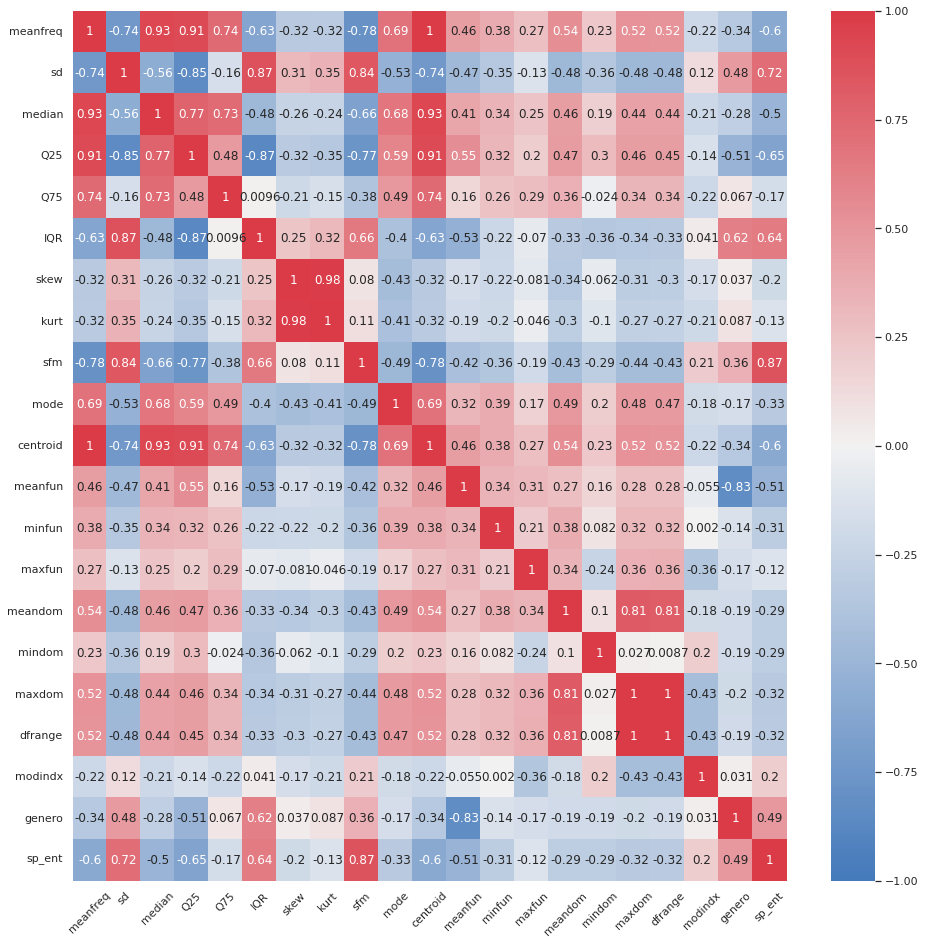

In [ ]:
sns.set_theme(style="white")
corr = voces_df.corr()
f, ax = plt.subplots(figsize=(16, 16))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap, vmin=-1, vmax=1)
plt.xticks(rotation=45)

In [ ]:
voces_df.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sfm,mode,...,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,genero,sp_ent
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,...,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.408216,0.165282,...,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752,0.500000,0.895127
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.177521,0.077203,...,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454,0.500079,0.044980
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.036876,0.000000,...,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000,0.000000,0.738651
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.258041,0.118016,...,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766,0.000000,0.861811
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.396335,0.186599,...,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357,0.500000,0.901767
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.533676,0.221104,...,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183,1.000000,0.928713
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.842936,0.280000,...,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374,1.000000,0.981997


It appearse the classes are balanced, since we have a mean of 0.5 across the value for *'genero'*.

In [ ]:
#Create PySpark SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .getOrCreate()
#Create PySpark DataFrame from Pandas
sparkDF=spark.createDataFrame(voces_df)
sparkDF.printSchema()
sparkDF.show()

root
 |-- meanfreq: double (nullable = true)
 |-- sd: double (nullable = true)
 |-- median: double (nullable = true)
 |-- Q25: double (nullable = true)
 |-- Q75: double (nullable = true)
 |-- IQR: double (nullable = true)
 |-- skew: double (nullable = true)
 |-- kurt: double (nullable = true)
 |-- sfm: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- centroid: double (nullable = true)
 |-- meanfun: double (nullable = true)
 |-- minfun: double (nullable = true)
 |-- maxfun: double (nullable = true)
 |-- meandom: double (nullable = true)
 |-- mindom: double (nullable = true)
 |-- maxdom: double (nullable = true)
 |-- dfrange: double (nullable = true)
 |-- modindx: double (nullable = true)
 |-- genero: double (nullable = true)
 |-- sp_ent: double (nullable = true)

+------------------+------------------+------------------+------------------+------------------+------------------+----------------+----------------+-----------------+------------------+------------------+-----

In [ ]:
from pyspark.ml.feature import VectorAssembler
# We will use any column that had a correlation higher than 0.2 to make the model
vectorAssembler = VectorAssembler(inputCols = ['sd', 'Q25', 'IQR', 'sp_ent', 'sfm', 'centroid', 'meanfun'], outputCol = 'features')
vectorized_df = vectorAssembler.transform(sparkDF)
vectorized_df= vectorized_df.select(['features', 'genero'])
vectorized_df.show(3)

+--------------------+------+
|            features|genero|
+--------------------+------+
|[0.06424126770313...|   1.0|
|[0.06731002879525...|   1.0|
|[0.08382942094450...|   1.0|
+--------------------+------+
only showing top 3 rows



In [ ]:
# Splitting data into training and testing 80% training and 20% testing
weights = [.8, .2]
#seed = 42 # seed=0L
rawTrainData, rawValidationData = vectorized_df.randomSplit(weights)

### Logistic regression

In [ ]:
# training the logistic regression madel
from pyspark.ml.classification import LogisticRegression
lr =  LogisticRegression(featuresCol = 'features', labelCol='genero', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(rawTrainData)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.2671296218158008,0.0,2.8479116870990757,0.9770642042007573,0.0,0.0,-8.650558007676219]
Intercept: -0.0101772543054235


In [ ]:
# Summary of the training data
# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = lr_model.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

objectiveHistory:
0.6931295351272637
0.6908301849322738
0.6741448754087824
0.6706695713620588
0.6679527886235372
0.6650235595707368
0.6631875184723638
0.6612483028770275
0.6601640714002878
0.6588342466923
0.6582090886791229
+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|0.001593625498007...|
|0.0|0.003187250996015...|
|0.0|0.004780876494023904|
|0.0|0.006374501992031873|
|0.0| 0.00796812749003984|
|0.0|0.009561752988047808|
|0.0|0.011155378486055778|
|0.0|0.012749003984063745|
|0.0|0.014342629482071713|
|0.0| 0.01593625498007968|
|0.0| 0.01752988047808765|
|0.0|0.019123505976095617|
|0.0|0.020717131474103586|
|0.0|0.022310756972111555|
|0.0| 0.02390438247011952|
|0.0| 0.02549800796812749|
|0.0|0.027091633466135457|
|0.0|0.028685258964143426|
|0.0|0.030278884462151396|
+---+--------------------+
only showing top 20 rows



LogisticRegression_0529d54a3bf4

In [ ]:
#Show model performance with training data
trainingSummary = lr_model.summary
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))
print("acurracy: " + str(trainingSummary.accuracy))
print("recall by label: " + str(trainingSummary.recallByLabel))
print("weighted recall: " + str(trainingSummary.weightedRecall))
print("precision by label: " + str(trainingSummary.precisionByLabel))
print("weighted precision: " + str(trainingSummary.weightedPrecision))
print("f1 by label: " + str(trainingSummary.fMeasureByLabel()))
print("weighted f1: " + str(trainingSummary.weightedFMeasure()))
print("TPR by label (Recall): " + str(trainingSummary.truePositiveRateByLabel))
print("FPR by label (1-Specificity):  " + str(trainingSummary.falsePositiveRateByLabel))

areaUnderROC: 0.9886121655111831
acurracy: 0.9449504950495049
recall by label: [0.9708661417322835, 0.9187250996015937]
weighted recall: 0.9449504950495049
precision by label: [0.9235955056179775, 0.9689075630252101]
weighted precision: 0.9461169440520674
f1 by label: [0.946641074856046, 0.9431492842535788]
weighted f1: 0.9449055512100673
TPR by label (Recall): [0.9708661417322835, 0.9187250996015937]
FPR by label (1-Specificity):  [0.08127490039840637, 0.029133858267716535]


In [ ]:
rawTrainData.describe().show()

+-------+------------------+
|summary|            genero|
+-------+------------------+
|  count|              2525|
|   mean| 0.497029702970297|
| stddev|0.5000902148296988|
|    min|               0.0|
|    max|               1.0|
+-------+------------------+



In [ ]:
# Testing the trained logistic regression model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
lr_predictions = lr_model.transform(rawValidationData)
lr_predictions.select("prediction","genero","features").show(5)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="genero", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lr_predictions,{evaluator.metricName: "accuracy"})

print("Test Error = %g " % (1.0 - accuracy))
print("Test Accuracy = %g " % ( accuracy))
print("Test F1 = ",evaluator.evaluate(lr_predictions, {evaluator.metricName: "f1"}))
print("Test Weighted Precision = ",evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"}))
print("Test Weighted Recall = ",evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"}))

+----------+------+--------------------+
|prediction|genero|            features|
+----------+------+--------------------+
|       0.0|   0.0|[0.01836324244445...|
|       0.0|   0.0|[0.03042230861157...|
|       0.0|   0.0|[0.03230787169387...|
|       0.0|   0.0|[0.03273914516091...|
|       0.0|   0.0|[0.03357290277383...|
+----------+------+--------------------+
only showing top 5 rows

Test Error = 0.0637636 
Test Accuracy = 0.936236 
Test F1 =  0.9362363919129082
Test Weighted Precision =  0.937255951223018
Test Weighted Recall =  0.9362363919129082


In [ ]:
#To find Area under the curve we will use the binary classificator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
areaUnderROC_Test = BinaryClassificationEvaluator(metricName = 'areaUnderROC', labelCol="genero")
ART = areaUnderROC_Test.evaluate(lr_predictions)
print("Area Under Curve test",ART)

Area Under Curve test 0.986128588852535


### Random Forest

In [ ]:
# Training and testing the Random Forest model
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol='genero')
rf_model = rf.fit(rawTrainData)
rf_predictions = rf_model.transform(rawValidationData)
rf_predictions.select('prediction', 'genero', 'features').show(5)

+----------+------+--------------------+
|prediction|genero|            features|
+----------+------+--------------------+
|       0.0|   0.0|[0.01836324244445...|
|       0.0|   0.0|[0.03042230861157...|
|       0.0|   0.0|[0.03230787169387...|
|       0.0|   0.0|[0.03273914516091...|
|       0.0|   0.0|[0.03357290277383...|
+----------+------+--------------------+
only showing top 5 rows



In [ ]:
#To find Area under the curve we will use the binary classificator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
areaUnderROC_Test = BinaryClassificationEvaluator(metricName = 'areaUnderROC', labelCol="genero")
ART = areaUnderROC_Test.evaluate(rf_predictions)
print("Area Under Curve test",ART)

# Testing the trained logistic regression model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="genero", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(rf_predictions,{evaluator.metricName: "accuracy"})

print("Test Error = %g " % (1.0 - accuracy))
print("Test Accuracy = %g " % ( accuracy))
print("Test F1 = ",evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"}))
print("Test Weighted Precision = ",evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedPrecision"}))
print("Test Weighted Recall = ",evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedRecall"}))

Area Under Curve test 0.9956004491510658
Test Error = 0.029549 
Test Accuracy = 0.970451 
Test F1 =  0.9704471485072572
Test Weighted Precision =  0.9704855788061508
Test Weighted Recall =  0.9704510108864697
